In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing

# import our csv file
file = pd.read_csv("churn_raw_data.csv", na_values="NA")

# final db we plan on putting the clean columns on
final_clean_csv = file

# Noting columns that do not need cleaning:
# CaseOrder (1-10,000 no repeats), Customer_id (10,000 unique ids), Interaction (10,000 unique interactions)
# City (10,000 count, no null values), State (10,000 count, 52 unique - DC and Puerto Rico account for the other 2)
# County (10,000 count, no null values), Zip (10,000 count, no nulls), Lat/Lng (10,000 count, no nulls), Area (10,000 count, expected 3 unique)
# Timezone (10,000 count, nothing weird about 25 uniques), Job (10,000 count, no null values)
# Education (10,000 count, 12 uniques check out), Employment (10,000 count, 5 uniques are good)
# Marital (10,000 count, 5 uniques make sense), Gender (10,000 count, 3 uniques as expected)
# Churn (10,000 count, all Yes/No), Email (10,000 count, reasonable min and max)
# Contacts (10,000 count, reasonable min/max), Yearly_equip_failure (10,000 count, min and max are sensible)
# Contract (10,000 count, 3 uniques are expected), Port_modem (10,000 count, all Yes/No)
# Tablet, Multiple, Online Security, OnlineBackup, DeviceProtection, Streaming TV, Streaming Movies (10,000 count, all Yes/No),
# PaperlessBilling (10,000 count, all Yes/No), PaymentMethod (10,000 count, all 4 uniques make sense),
# MonthlyCharge (10,000 count, descriptors make sense), item1-8 (10,000 count, on expected range of 1-8)
#
# Needs cleaning:
# Job's done!
#
# Columns that have been cleaned:
# Children (replaced missing w/ 0), Techie (replaced values), InternetService (replaced values), Phone/TechSupport (replaced nan with "No")
# Tenure (replaced missing, made floats), Population (averaged), Age (averaged), Income (replaced with median)
# Outage_sec_perweek (set floor at 0, bumped up neg values), Bandwidth_GB_Year (set 0s to avg)

# CLEANING CHILDREN
child_clean = file["Children"]
child_clean = pd.to_numeric(child_clean, errors="coerce")
child_clean = child_clean.fillna(0)
# child_clean.unique() found no null values!
# replace the unclean column with our clean one
final_clean_csv["Children"] = child_clean

# CLEANING TECHIE
techie_clean = file["Techie"]
# Equating a blank value to "No"
techie_clean = techie_clean.fillna("No")
# techie_clean.unique() found no nulls!
# pop it onto our final file
final_clean_csv["Techie"] = techie_clean

# CLEANING INTERNETSERVICE
service_clean = file["InternetService"]
service_clean = service_clean.fillna("No Service")
# service_clean.unique() gives us our 3 expected values
# put the cleaned column in our final file
final_clean_csv["InternetService"] = service_clean

# CLEANING PHONE
phone_clean = file["Phone"]
phone_clean = phone_clean.fillna("No")
# phone_clean.unique() only Yes and No
# into our final file
final_clean_csv["Phone"] = phone_clean

# CLEANING TECHSUPPORT
tech_clean = file["TechSupport"]
tech_clean = tech_clean.fillna("No")
# tech_clean.unique() finds Yes and No
final_clean_csv["TechSupport"] = tech_clean

# CLEANING TENURE
tenure_clean = file["Tenure"]
# Making Tenure floats
tenure_clean = pd.to_numeric(tenure_clean, errors="coerce")
# any blank values means zero tenure time
tenure_clean = tenure_clean.fillna(tenure_clean.mean())
# tenure_clean.describe() shows 10k count, and float type
final_clean_csv["Tenure"] = tenure_clean

# CLEANING POPULATION
pop_clean = file["Population"]
pop_avg = pop_clean.mean()
# using replace instead of fillna because there are values
# the values just don't make logical sense
pop_clean = pop_clean.replace(to_replace=0, value=pop_avg)
final_clean_csv["Population"] = pop_clean

# CLEANING AGE
age_clean = file["Age"]
# filling "NA" values with the average age
age_clean = age_clean.fillna(age_clean.mean())
final_clean_csv["Age"] = age_clean

# CLEANING INCOME
income_clean = file["Income"]
# using the median instead of mean, because income can be very stratified
income_clean = income_clean.fillna(income_clean.median())
final_clean_csv["Income"] = income_clean

# CLEANING OUTAGE_SEC_PERWEEK
outage_clean = file["Outage_sec_perweek"]
outage_clean = outage_clean.clip(lower=0)
final_clean_csv["Outage_sec_perweek"] = outage_clean

# CLEANING BANDWIDTH_GB_YEAR
bandwidth_clean = file["Bandwidth_GB_Year"]
bandwidth_clean = bandwidth_clean.fillna(bandwidth_clean.mean())
final_clean_csv["Bandwidth_GB_Year"] = bandwidth_clean

# Outport to CSV
final_clean_csv.to_csv("D206_Final_Data.csv")

Number missing : Series([], dtype: int64) 
Percent missing : Series([], dtype: float64)


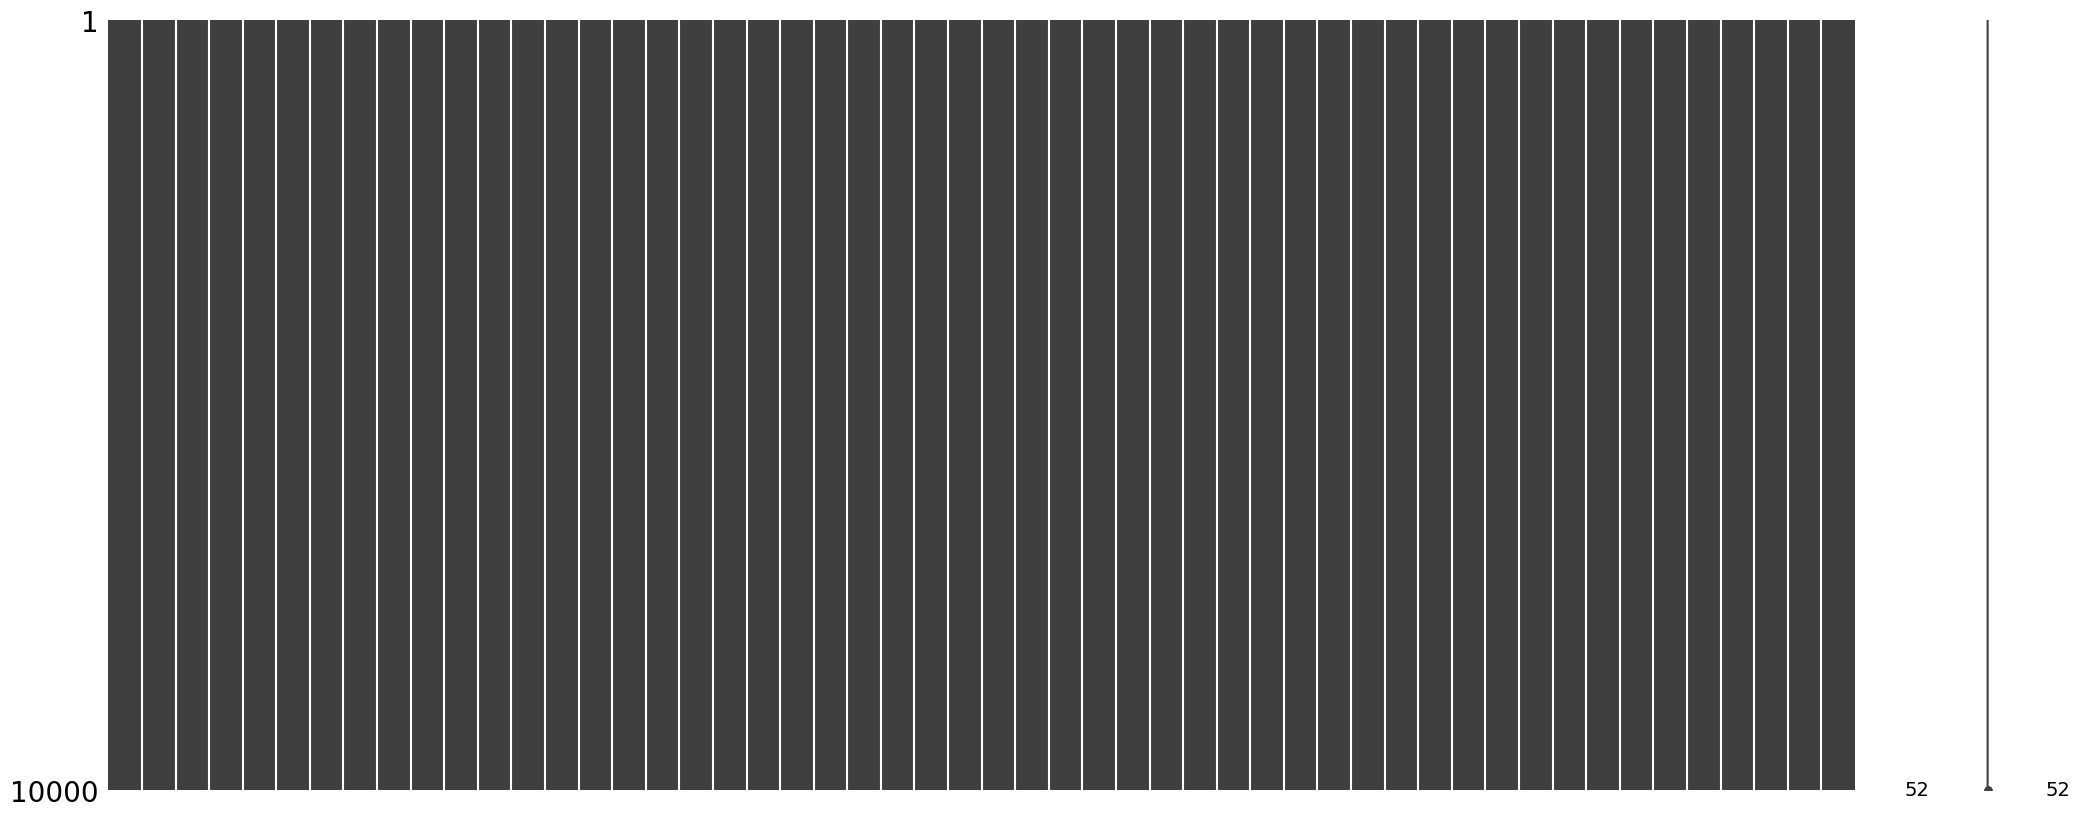

In [2]:
# Checking our final CSV
msno.matrix(final_clean_csv)
file_nullity = final_clean_csv.isnull()
sum_missing = file_nullity.sum()
percent_missing = file_nullity.mean()*100
sum_missing = sum_missing[sum_missing != 0]
percent_missing = percent_missing[percent_missing != 0]
print("Number missing :", sum_missing,
     "\nPercent missing :", percent_missing)

In [3]:
# create a dataframe without our categorical variables
churn_PCA = final_clean_csv[["Population", "Age", "Children", "Income", "MonthlyCharge", "Outage_sec_perweek", "Contacts", 
                             "Yearly_equip_failure", "Tenure", "Bandwidth_GB_Year"]]

# Normalizing the data
churn_PCA_normal = (churn_PCA-churn_PCA.mean())/churn_PCA.std()
pca = PCA(n_components=churn_PCA_normal.shape[1])
pca.fit(churn_PCA_normal)
churn_PCA2 = pd.DataFrame(pca.transform(churn_PCA_normal),columns=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10"])

# loading matrix
loadings = pd.DataFrame(pca.components_.T, columns=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10"],
                        index=churn_PCA_normal.columns)
loadings

# scree plot creation
# cov_matrix = np.dot(churn_PCA_normal.T, churn_PCA_normal)/churn_PCA.shape[0]
# eigenvalues = [np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)) for eigenvector in pca.components_]
# plt.plot(eigenvalues)
# plt.xlabel("number of components")
# plt.ylabel("eigenvalues")
# plt.axhline(y=1, color="purple")
# plt.show()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Population,-0.001267,-0.080573,0.233659,-0.459865,-0.021895,0.812504,-0.072051,0.248066,-0.008010,-0.000357
Age,-0.012024,-0.051200,0.437231,0.605977,0.009166,0.033473,-0.464272,0.455079,0.120533,0.021833
Children,-0.004117,0.051227,-0.611642,0.151932,0.137284,0.086719,0.307112,0.692113,0.014441,-0.015992
Income,0.005950,0.004149,-0.208914,0.172388,0.837288,0.250824,-0.254498,-0.305927,-0.065260,0.001168
MonthlyCharge,0.045560,0.694461,0.135720,-0.035179,0.019387,-0.038086,-0.062916,0.118629,-0.688352,-0.048020
Outage_sec_perweek,0.022646,0.705191,0.005759,-0.035898,0.013298,0.075864,0.002270,-0.066841,0.700333,0.000507
Contacts,0.004667,-0.014073,0.504938,0.230821,0.290398,0.064978,0.776376,-0.013793,0.005316,-0.002850
Yearly_equip_failure,0.015512,0.069395,-0.250857,0.559100,-0.441194,0.506749,0.114891,-0.373936,-0.122232,-0.002490
Tenure,0.705118,-0.059686,0.007921,0.006918,-0.001200,-0.005731,-0.014381,0.004318,0.039201,-0.705223
Bandwidth_GB_Year,0.706937,-0.009995,-0.008609,-0.008359,0.001155,-0.005389,0.006584,0.013275,-0.011857,0.706828
